
## Green HPC: An analysis of the domain based on Top500 - EXPERIMENTS

____

### Summary:

This notebook analyzes the evolution of performance, energy efficiency, and environmental impact metrics (electric consumption and carbon footprint) of supercomputers listed in the Top500 and Green500 rankings. The notebook leverages data on the maximum and average performance, energy efficiency, and CO2 emissions of these systems over time from the top500 and Green500 lists. It highlights the performance progression of the top-ranking systems while projecting future trends using Koomey’s and Moore’s law. Several visualizations are included to explore trends in energy consumption, carbon footprint, and the ratio of performance to energy use.

> Metrics:
- Power : KW
- Rmax/Rpeak : GFlops
- Energy efficiency : Gflops/Watts

### Imports:

In [1]:
# Imports
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from scipy.stats import linregress
import seaborn as sns
import numpy as np

from typing import List
from scipy.optimize import curve_fit

In [2]:
# to remove warnings
warnings.filterwarnings('ignore')

### Utilities:

In [3]:
# Some useful functions to:
## filter data:
def read_filter_top500_data(y: int, m: int, range: int, fields: List, save: bool = False):
    """Reads and filters a specific top500 list by range and fields of interest.

    Args:
        y (int): year.
        m (int): month.
        range (int): the number of elements to keep.
        fields (list): the fields (columns) to keep
        save (bool): save the generated df into a csv file.

    Returns:
        (pd.Dataframe): the generated dataframe.
    """
    # reading data
    file_path = f"./data/top500/TOP500_{y}{m}.xls{'x'*min(1, max(0, y-2019))}"
    df_f = pd.read_excel(
            file_path, 
            header=1 - min(1, max(0, y - 2007))
        )
    # truncating by range
    df_f = df_f.iloc[:range]

    # some data cleaning + scaling (Tflops to Gflops)
    if y < 2008 or (y == 2008 and m == '06'):
        df_f['Cores'] = df_f['Processors']
    elif y > 2011 or (y == 2011 and m == '11'):
        df_f['Cores'] = df_f['Total Cores']
        if y > 2017:
            df_f['RMax'] = df_f['Rmax [TFlop/s]'] * 1000 
            df_f['RPeak'] = df_f['Rpeak [TFlop/s]'] * 1000
        else:
            df_f['RMax'] = df_f['Rmax'] * (1000 - 999 * min(1, max(0, 2017 - y)))
            df_f['RPeak'] = df_f['Rpeak'] * (1000 - 999 * min(1, max(0, 2017 - y)))

    df_f['perf_percent'] = df_f['RMax']/df_f['RPeak']
    df_f.loc[df_f['perf_percent'] > 1, 'RPeak'] *= 10
    df_f['perf_percent'] = df_f['RMax']/df_f['RPeak']
    
    # choosing the fields of interest 
    df_f = df_f[fields]

    # adding the ranking date
    df_f['rank_year'] = '-'.join([str(y), str(m)])
    
    # saving the newly created df                             
    if save:
        df_f.to_csv(f'./data/output_data/TOP500_{y}{m}.csv')
    
    return df_f

def read_filter_green500_data(y: int, m: int, range: int, fields: List, save: bool = False):
    """Reads and filters a specific Green500 list by range and fields of interest.

    Args:
        y (int): year.
        m (int): month.
        range (int): the number of elements to keep.
        fields (list): the fields (columns) to keep
        save (bool): save the generated df into a csv file.

    Returns:
        (pd.Dataframe): the generated dataframe.
    """
    # reading data
    df_f = pd.read_excel(f"./data/green500/#green500_{y}_{m}.xlsx", header=0)

    # truncating by range
    df_f = df_f.iloc[:range]

    # homogenising the fields
    if y == 2014 and m == '06':
        df_f['TOP500 Rank'] = df_f['Top500_Rank']
        df_f['Rank'] = df_f['green500_rank']
        df_f['G_eff'] = df_f['mflops_per_watt'] / 1000
    elif y == 2015:
        df_f['TOP500 Rank'] = df_f['top500_rank']
        df_f['Rank'] = df_f['green500_rank']
        df_f['G_eff'] = df_f['mflops_per_watt'] / 1000
        df_f['Power'] = df_f['total_power']
    elif y == 2016 and m == '06' or (y == 2014 and m == '11'):
        df_f['TOP500 Rank'] = df_f['Top500_Rank']
        df_f['G_eff'] = df_f['Mflops/Watt'] / 1000
        df_f['Rank'] = df_f['Green500_Rank']
    elif y == 2016 and m == '11':
        df_f['TOP500 Rank'] = df_f['Rank']
        df_f['Rank'] = df_f['Green500_Rank']
        df_f['G_eff'] = df_f['Mflops/Watt'] / 1000
    elif y < 2020:
        df_f['G_eff'] = df_f['Power Effeciency [GFlops/Watts]']
    elif y < 2022:
        df_f['G_eff'] = df_f['Power Efficiency [GFlops/Watts]']
    else:
        df_f['G_eff'] = df_f['Energy Efficiency [GFlops/Watts]']
    
    if y < 2008 or (y == 2008 and m == '06'):
        df_f['Cores'] = df_f['Processors']
    elif y> 2011 or (y == 2011 and m == '11'):
        df_f['Cores'] = df_f['Total Cores']
        if y >= 2017:
            df_f['RMax'] = df_f['Rmax [TFlop/s]'] * 1000
            df_f['RPeak'] = df_f['Rpeak [TFlop/s]'] * 1000
            df_f['Power'] = df_f['Power (kW)']
        else:
            df_f['RMax'] = df_f['Rmax'] * (1000 - 999 * min(1, max(0, 2017 - y)))
            df_f['RPeak'] = df_f['Rpeak'] * (1000 - 999 * min(1, max(0, 2017 - y)))
    
    # choosing the fields of interest
    df_f = df_f[fields]
    
    # adding the ranking date
    df_f['rank_year'] = '-'.join([str(y), str(m)])
    # performance percentage
    df_f['perf_percent'] = df_f['RMax']/df_f['RPeak']
    df_f.loc[df_f['perf_percent'] > 1, 'RPeak'] *= 10
    df_f['perf_percent'] = df_f['RMax']/df_f['RPeak']

    # HPC type (heterogeneous / homogeneous:
    df_f['Accelerator/Co-Processor'] = list(df_f['Accelerator/Co-Processor'].notnull().astype('int'))


    # saving the newly created df                             
    if save:
        df_f.to_csv(f'./data/output_data/GREEN500_{y}{m}.csv')

    return df_f


## calculate apparitions:
def calc_apparition(l: List, unit: str = 'y'):
    """Calculates the apparition time of an HPC in the top500 list by years/months.
    
    Args:
        l (list): the list of apparition dates.
        unit (str): output unit.
        
    Returns:
        the apparition time in the chosen unit.
    """
    c = 0
    dates = []
    for el in l:
        if el[1] in dates:
            l.remove(el)
            continue
        dates.append(el[1])
        c+=1

    # return the apparition time 
    if unit == 'y':
        return c * 6 / 12

    return c

## calculate other values ...
def exp_funct(x: float, a: float, b: float):
    """Calculates the exp."""
    return a * np.power(np.exp(x), b)

def moore_funct(x: float, df: pd.DataFrame, metric: str = "RMax"):
    """Calculates moore's prediction."""
    return df.iloc[0][metric] * 2 ** (x/4)

def koomey_funct(x: float, df: pd.DataFrame, y: float = 0, metric: str = "G_eff"):
    """Calculates koomey's prediction."""
    return df.iloc[y][metric] * 2 ** ((x-y)/3)


### Data:

In [4]:
# Our fields of interest.
main_fields = ['Computer', 'Year', 'Country', 'Cores', 'Rank', 'Site', 'RMax', 'RPeak']
main_green_fields = ['Computer', 'Year', 'Country', 'Cores', 'Site', 'Power',
                     'RMax', 'RPeak', 'TOP500 Rank', 'Rank', 'Accelerator/Co-Processor', 'G_eff']
# concatenate all the extracted dataframes into one single one from the year 1993 to 2023.
concat_df = pd.concat(
        [read_filter_top500_data(y, m, range=500, fields=main_fields) 
        for y in range(1994, 2024) for m in ['06', '11']], ignore_index=True
    )

green_concat_df = pd.concat(
        [read_filter_green500_data(y, m, range=100, fields=main_green_fields) 
        for y in range(2014, 2024) for m in ['06', '11']], ignore_index=True
    )

# some info about the concatenated dataframe
concat_df.info()

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but 

In [5]:
# adding a minimum rank column.
tmp_fields = list(main_fields)
tmp_fields.remove('Rank')

concat_df['min_rank'] = concat_df[main_fields].groupby(tmp_fields).transform('min')
green_concat_df['g_min_rank'] = green_concat_df[tmp_fields + ['TOP500 Rank']].groupby(tmp_fields).transform('min')

# visualizing the output
concat_df.tail()


,Computer,Year,Country,Cores,Rank,Site,RMax,RPeak,rank_year,min_rank
29995,"Lenovo ThinkSystem SR675 V3, AMD EPYC 9334 32C...",2023,South Korea,3936,496,Science Institute,2028000.0,3249180.0,2023-11,496
29996,"ThinkSystem HR650X, Xeon Gold 6133 20C 2.5GHz,...",2020,China,48000,497,Service Provider T,2027520.0,3840000.0,2023-11,194
29997,"Sugon TC6000, Xeon Gold 6140 18C 2.3GHz, 10G E...",2019,China,55440,498,Telecom Company,2026000.0,4080384.0,2023-11,152
29998,"Inspur NF5468M5, Xeon Gold 5120 14C 2.2GHz, NV...",2020,China,48880,499,Bank I,2016000.0,44982270.0,2023-11,230
29999,"PowerEdge C6420, Xeon Platinum 8260 24C 2.4GHz...",2021,United States,43200,500,MIT Lincoln Laboratory Supercomputing Center,2015000.0,53084160.0,2023-11,279


___
### Experiments:

#### 1. **TOP500 :** The Proportion of Top500 Systems by Apparition Time (Years)

Avg shelflife: 1.44 | Max shelflife: 12.50 | Min shelflife: 0.50.  [+/- 0->6 months]


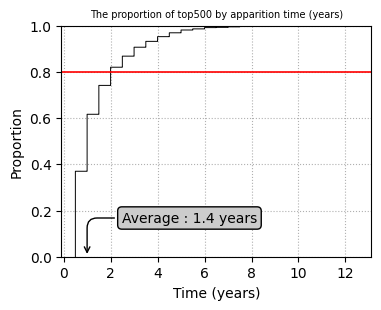

In [6]:
# plotting: The proportion of top500 by apparition time (years)

# Plot settings
offset = 50
plt.figure(figsize=(4, 3))
plt.grid(linestyle='dotted')
plt.title('The proportion of top500 by apparition time (years)', fontsize=7)

# Data reformatting
g_df = concat_df.copy(deep=True)
g_df['rank_year'] = g_df[['Rank', 'rank_year']].apply(lambda x: [x['Rank'], x['rank_year']], axis=1)
g_df = g_df.groupby(['Computer', 'Year', 'Country', 'Cores'])['rank_year'].apply(list)

# Plotting the data
ax = sns.ecdfplot(data=g_df.reset_index()['rank_year'].apply(calc_apparition), color='black', linewidth=0.7)

# Axis settings
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Proportion')

# Apparition time [mean, max, min]
minimum, average, maximum = g_df.apply(calc_apparition).min(), g_df.apply(calc_apparition).mean(), g_df.apply(calc_apparition).max()
print(
    "Avg shelflife: {0:.2f} | Max shelflife: {1:.2f} | Min shelflife: {2:.2f}.  [+/- 0->6 months]".format(
        average,
        maximum,
        minimum
        )
    )

# Addiung an arrow to point out the average
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

ax.annotate(
        f'Average : {average:.1f} years',
        xy=(1, 0), 
        xytext=(0.5*offset, 0.5*offset), textcoords='offset points',
        bbox=dict(boxstyle="round", fc="0.8"), arrowprops=arrowprops
    )

# Highlighting the 80% proportion threshold
plt.axhline(y = 0.8, color = 'r', linewidth=1.2)

# Uncomment to save the figure
# plt.savefig("./figures/top500_lifespan.png", format='png', bbox_inches="tight")

plt.show()

#### 2. **TOP500 :** The Average Presence Time per Issue Year

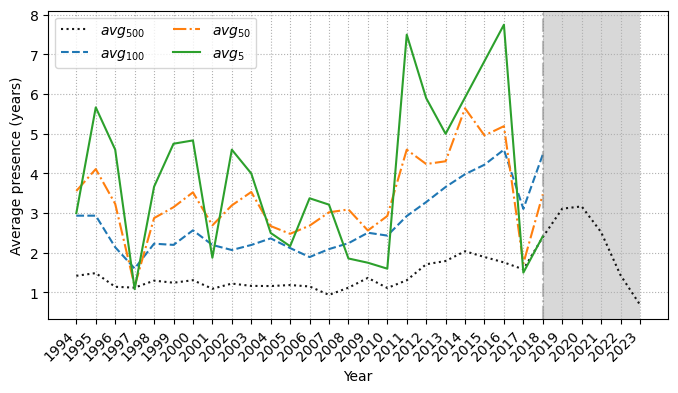

In [7]:
# Plotting: The average presence (years)

# Plot settings
offset = 50
plt.figure(figsize=(8, 4))
plt.grid(linestyle='dotted')

# Data reformatting
g_df = concat_df.copy(deep=True)

# Create a combined 'rank_year' column with Rank and Year
g_df['rank_year'] = g_df[['Rank', 'rank_year']].apply(lambda x: [x['Rank'], x['rank_year']], axis=1)

# Group data by Computer, Year, Country, and Cores, and aggregate 'rank_year'
g_df = g_df.groupby(['Computer', 'Year', 'Country', 'Cores'])['rank_year'].apply(list)

# Function to calculate the minimum rank from a list
def calc_min(l):
    min_rank = int(l[0][0])
    for x in l:
        if x[0] < min_rank:
            min_rank = x[0]
    return min_rank

# Function to calculate the first year of ranking
def calc_rank(l):
    first_year = int(str(l[0][1]).split('-')[0])
    for x in l:
        if int(x[1].split('-')[0]) < first_year:
            first_year = int(x[1].split('-')[0])
    return first_year

# Set color palette for the plot
sns.color_palette("colorblind")

# Reset index and apply functions to calculate min rank and first year
g_df = g_df.reset_index()
g_df['min_rank'] = g_df['rank_year'].apply(calc_min)
g_df['frst_y'] = g_df['rank_year'].apply(calc_rank)
g_df['n_apparitions'] = g_df['rank_year'].apply(calc_apparition)

# Define years to filter for latest apparitions
latest_y = [2019, 2020, 2021, 2022, 2023]

# Filter data based on rank thresholds
g_df_100 = g_df[g_df.min_rank <= 100]
g_df_25 = g_df[g_df.min_rank <= 25]
g_df_5 = g_df[g_df.min_rank <= 5]

# Plot the data
# Average for all top500
ax = sns.lineplot(data=g_df[['frst_y', 'n_apparitions']].groupby('frst_y').mean(),
                  x='frst_y', y='n_apparitions', label=r'$avg_{500}$',
                  color='black', alpha=0.9, linestyle='dotted')

# Average for top100, excluding recent years
sns.lineplot(data=g_df_100[['frst_y', 'n_apparitions']][~g_df_100['frst_y'].isin(latest_y)]
             .groupby('frst_y').mean(), x='frst_y', y='n_apparitions',
             label=r'$avg_{100}$', linestyle='dashed')

# Average for top25, excluding recent years
sns.lineplot(data=g_df_25[['frst_y', 'n_apparitions']][~g_df_25['frst_y'].isin(latest_y)]
             .groupby('frst_y').mean(), x='frst_y', y='n_apparitions',
             label=r'$avg_{50}$', linestyle='dashdot')

# Average for top5, excluding recent years
sns.lineplot(data=g_df_5[['frst_y', 'n_apparitions']][~g_df_5['frst_y'].isin(latest_y)]
             .groupby('frst_y').mean(), x='frst_y', y='n_apparitions',
             label=r'$avg_{5}$')

# Axis settings
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('Year')
ax.set_ylabel('Average presence (years)')

# Rotate x-ticks for better readability
plt.xticks(g_df["frst_y"].unique(), rotation=45, ha='right')

# Highlight recent years (2018-2023) with shaded region and vertical line
plt.axvspan(2018, 2023, facecolor='grey', alpha=0.3)
plt.axvline(2018, color="grey", alpha=0.5, linestyle="dashdot")

# Display legend in upper left with 2 columns
plt.legend(loc='upper left', ncols=2)

# Uncomment to save the figure
# plt.savefig("./figures/top500_avg_apparition.png", format='png', bbox_inches="tight")

plt.show()


#### 3. **TOP500 :** The Number of New Machines per Year

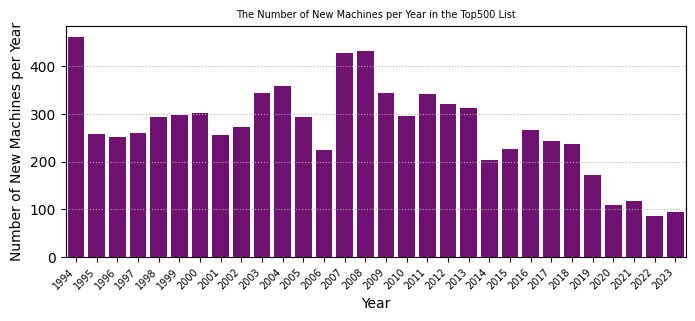

In [8]:
# Plotting: The number of new machines per year in the Top500 list

# Plot settings
plt.figure(figsize=(8, 3))
plt.grid(linestyle='dotted') 
plt.title('The Number of New Machines per Year in the Top500 List', fontsize=7)

# Data reformatting
g_df = concat_df.copy(deep=True)

# Create a combined 'rank_year' column containing Rank and Year
g_df['rank_year'] = g_df[['Rank', 'rank_year']].apply(lambda x: [x['Rank'], x['rank_year']], axis=1)

# Group the data by Computer, Year, Country, and Cores
g_df = g_df.groupby(['Computer', 'Year', 'Country', 'Cores'])['rank_year'].apply(list)

# Function to calculate the minimum rank from a list
def calc_min(l):
    min_rank = int(l[0][0])
    for x in l:
        if x[0] < min_rank:
            min_rank = x[0]
    return min_rank

# Function to calculate the first year of ranking
def calc_rank(l):
    first_year = int(str(l[0][1]).split('-')[0])
    for x in l:
        if int(x[1].split('-')[0]) < first_year:
            first_year = int(x[1].split('-')[0])
    return first_year

# Reset index and apply functions to calculate min rank and first year of appearance
g_df = g_df.reset_index()
g_df['min_rank'] = g_df['rank_year'].apply(calc_min)
g_df['apparition year'] = g_df['rank_year'].apply(calc_rank)

# Group data by apparition year and count the number of machines
grouped_data = g_df[['apparition year', 'Computer']].groupby('apparition year').count()
grouped_data.rename(columns={'Computer': 'Number of machines'}, inplace=True)
grouped_data.reset_index(inplace=True)

# Plot the data: Bar plot of the number of new machines per year
ax = sns.barplot(data=grouped_data, x='apparition year', y='Number of machines', color='purple')

# Axis settings
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('Year')
ax.set_ylabel('Number of New Machines per Year')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=7)

# Uncomment to save the figure
# plt.savefig("./figures/top500_nbr_new_machines.png", format='png', bbox_inches="tight")

# Show the plot
plt.show()


#### 4. **TOP500 :** The Number of New Machines Per Year (Grouped By Country)

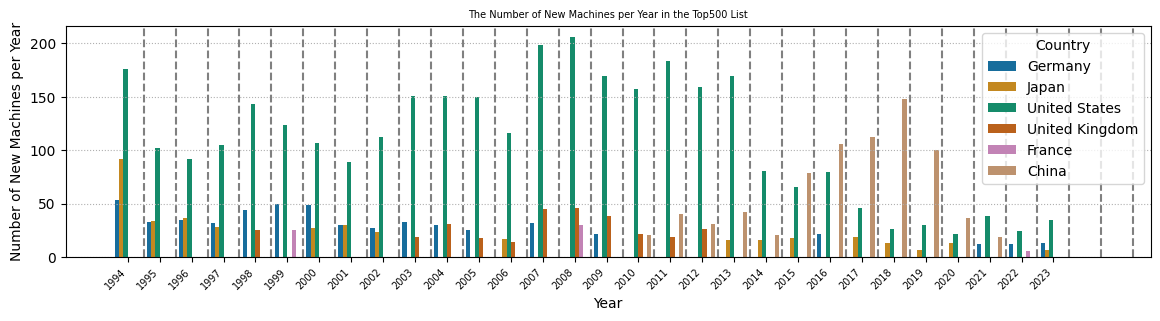

In [9]:
# Plotting: The number of new machines per year in the Top500 list, grouped by country

# Plot settings
plt.figure(figsize=(14, 3))
plt.grid(linestyle='dotted') 
plt.title('The Number of New Machines per Year in the Top500 List', fontsize=7)
sns.color_palette("colorblind")

# Data reformatting
g_df = concat_df.copy(deep=True)

# Create a combined 'rank_year' column containing Rank and Year
g_df['rank_year'] = g_df[['Rank', 'rank_year']].apply(lambda x: [x['Rank'], x['rank_year']], axis=1)

# Group the data by Computer, Year, Country, and Cores
g_df = g_df.groupby(['Computer', 'Year', 'Country', 'Cores'])['rank_year'].apply(list).reset_index()

# Apply functions to calculate the minimum rank and first year of appearance
g_df['min_rank'] = g_df['rank_year'].apply(calc_min)
g_df['apparition year'] = g_df['rank_year'].apply(calc_rank)

# Group by apparition year and country, and count the number of machines
draft_df = g_df[['Country', 'apparition year', 'Computer']].groupby(['apparition year', 'Country']).count().reset_index()

# Select the top 3 countries with the most machines per year
draft_df_2 = draft_df.groupby('apparition year')['Computer'].nlargest(3).reset_index()['level_1'].tolist()

# Filter the draft_df to keep only the top 3 countries per year
draft_df = draft_df[draft_df.index.isin(draft_df_2)]
draft_df['Count'] = draft_df['Computer']

# Plotting the data
ax = sns.barplot(data=draft_df, x='apparition year', y='Count', hue='Country', palette="colorblind")

# Axis settings
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('Year')
ax.set_ylabel('Number of New Machines per Year')
plt.xticks(rotation=45, ha='right', fontsize=7)

# Adding vertical lines for visual separation between years
for i in range(len(draft_df['apparition year'].to_list())//2 - 13):
    plt.axvline(x=i + 0.5, color='grey', linestyle='--')

# Uncomment to save the figure
# plt.savefig("./figures/top500_nbr_new_machines_per_country.png", format='png', bbox_inches="tight")

# Show the plot
plt.show()


#### 5. **TOP500 :** The Number of New Machines Per Year (Grouped By Region)

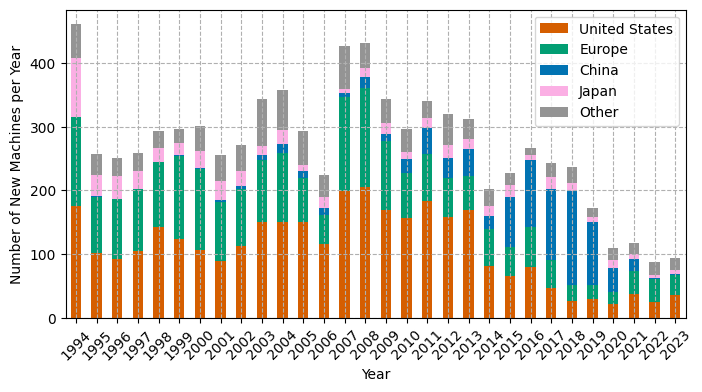

In [10]:
# Plotting: The number of new machines per year in the Top500 list, categorized by region

# Plot settings
figure, ax = plt.subplots(1, 1, figsize=(8, 4))

# Use a colorblind-friendly palette
colors = sns.color_palette("colorblind")

# Data reformatting
g_df = concat_df.copy(deep=True)

# Create a combined 'rank_year' column containing Rank and Year
g_df['rank_year'] = g_df[['Rank', 'rank_year']].apply(lambda x: [x['Rank'], x['rank_year']], axis=1)

# Group the data by Computer, Year, Country, and Cores
g_df = g_df.groupby(['Computer', 'Year', 'Country', 'Cores'])['rank_year'].apply(list).reset_index()

# Apply functions to calculate the minimum rank and first year of appearance
g_df['min_rank'] = g_df['rank_year'].apply(calc_min)
g_df['apparition year'] = g_df['rank_year'].apply(calc_rank)

# Defining regions and grouping European countries under 'Europe'
main = ['Europe', 'United States', 'China', 'Japan']
eu_countries = ['United Kingdom', 'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 
                'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 
                'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 
                'Slovenia', 'Spain', 'Sweden']

# Group European countries under 'Europe' and the rest as 'Other'
g_df.loc[g_df['Country'].isin(eu_countries), 'Country'] = "Europe"
g_df.loc[~g_df['Country'].isin(main), 'Country'] = "Other"

# Group the data by apparition year and country, and count the number of machines
draft_df = g_df[['Country', 'apparition year', 'Computer']].groupby(['apparition year', 'Country']).count().reset_index()

# Add a 'Count' column for easier plotting
draft_df['Count'] = draft_df['Computer']

# Pivot the data to get the counts for each country per apparition year
draft_pivot = pd.pivot_table(draft_df, values='Count', index='apparition year', columns='Country', aggfunc="sum")

# Reorder columns to display the most important countries first
draft_pivot.columns = pd.CategoricalIndex(draft_pivot.columns.values, 
                                          ordered=True, 
                                          categories=['United States', 'Europe', 'China', 'Japan', 'Other'])

# Sort columns for consistent display order
draft_pivot = draft_pivot.sort_index(axis=1)

# Plot the stacked bar chart
draft_pivot.plot(kind='bar', stacked=True, ax=ax, color=[colors[i] for i in [3, 2, 0, 6, 7]])

# Axis settings
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Year')
ax.set_ylabel('Number of New Machines per Year')
ax.grid(linestyle='--')

# Uncomment to save the figure
#figure.savefig("./figures/top500_nbr_new_machines_per_country_cum.png", format='png', bbox_inches="tight")

# Show the plot
plt.show()


#### 6. **TOP500 :** The Rmax Evolution in the Top500 List (With Moore's Law Projection)

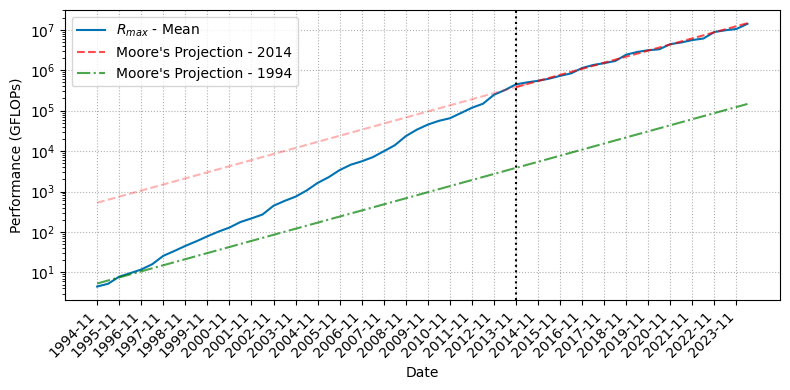

In [11]:
# Plotting: The maximum (and mean) Rmax Evolution of the Top500 supercomputers over time, along with Moore’s law projections

# Plot settings
plt.figure(figsize=(8, 4))
plt.grid(linestyle='dotted')
plt.yscale('log')  # Logarithmic scale for performance
colors = sns.color_palette("colorblind")

# Function to calculate Moore's law prediction
def moore_funct_tmp(x: float, df: pd.DataFrame, i, metric: str = "RMax"):
    """Calculates Moore's prediction based on a given metric."""
    return df.iloc[i][metric] * 2 ** (x/4)

# Mean and max dataframes for RMax and RPeak
log_df = concat_df.copy(deep=True)
log_df_mean = log_df[['rank_year', 'RMax', 'RPeak']].groupby('rank_year').mean().reset_index()
log_df_max = log_df[['rank_year', 'RMax', 'RPeak']].groupby('rank_year').max().reset_index()

# Creating an index for plotting
log_df_mean['index'] = log_df_mean.index + 1
log_df_max['index'] = log_df_max.index + 1

# Plotting the mean RMax values over time
sns.lineplot(data=log_df_mean, x='index', y='RMax', label=r'$R_{max}$ - Mean', color=colors[0], alpha=1)

# Curve fitting the maximum and mean RMax values for different periods
popt_max, _ = curve_fit(exp_funct, log_df_mean['index'][40:], log_df_mean['RMax'][40:])
popt_mean, _ = curve_fit(exp_funct, log_df_mean['index'][:40], log_df_mean['RMax'][:40])

# Plotting Moore's projection from 2014 onwards
plt.plot(
    log_df_mean['index'][38:], 
    [moore_funct_tmp(x, log_df_mean, 16) for x in log_df_mean['index'][38:]], 
    'g-', label="Moore's Projection - 2014", ls='dashed', alpha=0.7, color='red'
)

# Plotting Moore's projection from 1994 onwards
plt.plot(
    log_df_mean['index'][:40], 
    [moore_funct_tmp(x, log_df_mean, 16) for x in log_df_mean['index'][:40]], 
    'g-', label=None, ls='dashed', alpha=0.3, color='red'
)

# Plotting the complete Moore's projection
plt.plot(
    log_df_mean['index'], 
    [moore_funct_tmp(x, log_df_mean, 0) for x in log_df_mean['index']], 
    'g-', label="Moore's Projection - 1994", ls='dashdot', alpha=0.7
)

# Adding a vertical line at the year 2014 (index 39)
plt.axvline(x=39, color='black', linestyle="dotted")

# Axis settings
plt.legend(ncol=1, loc=2, fontsize='10')
plt.xticks(
    ticks=np.arange(1, max(log_df_max['index']), 2),
    labels=[log_df_max['rank_year'][i] for i in np.arange(1, max(log_df_max['index']), 2)],
    rotation=45, ha='right', fontsize=10
)
plt.tight_layout()

# Labels for x and y axes
plt.xlabel('Date')
plt.ylabel('Performance (GFLOPs)')

# Uncomment to save the figure
# plt.savefig("./figures/top500_performance_evolution.png", format='png', bbox_inches="tight")

# Show the plot
plt.show()


#### 7. **TOP500 :** The Performance Evolution Rate (Rmax(y) / Rmax(y-1))

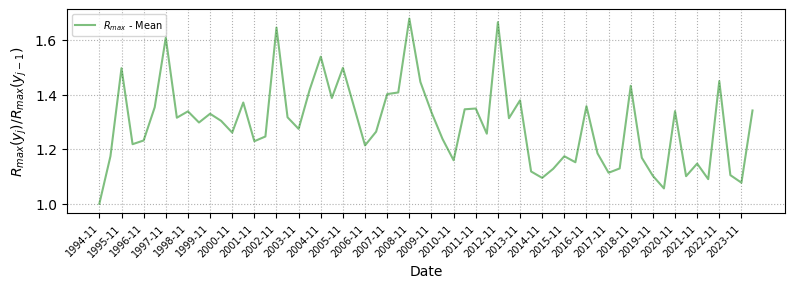

In [12]:
# Plotting: The performance evolution rate (Rmax(y) / Rmax(y-1)) of the Top500 Supercomputers over time

# Plot settings
plt.figure(figsize=(8, 3))
plt.grid(linestyle='dotted')

# Data reformatting for mean & max Rmax values over time
log_df = concat_df.copy(deep=True)

# Calculate mean and max Rmax and RPeak values grouped by rank year
log_df_evol_mean = log_df[['rank_year', 'RMax', 'RPeak']].groupby('rank_year').mean().reset_index()
log_df_evol_max = log_df[['rank_year', 'RMax', 'RPeak']].groupby('rank_year').max().reset_index()

# Create index column for plotting
log_df_evol_mean['index'] = log_df_evol_mean.index + 1
log_df_evol_max['index'] = log_df_evol_max.index + 1

# Calculate the year-over-year evolution of Rmax for mean values
log_df_evol_mean['prev_year_Rmax'] = log_df_evol_mean['RMax'].shift(1)
log_df_evol_mean.iloc[0, log_df_evol_mean.columns.get_loc('prev_year_Rmax')] = log_df_evol_mean.iloc[0]['RMax']  # Handle first year
log_df_evol_mean['Rmax_evol'] = log_df_evol_mean['RMax'] / log_df_evol_mean['prev_year_Rmax']

# Calculate the year-over-year evolution of Rmax for max values
log_df_evol_max['prev_year_Rmax'] = log_df_evol_max['RMax'].shift(1)
log_df_evol_max.iloc[0, log_df_evol_max.columns.get_loc('prev_year_Rmax')] = log_df_evol_max.iloc[0]['RMax']  # Handle first year
log_df_evol_max['Rmax_evol'] = log_df_evol_max['RMax'] / log_df_evol_max['prev_year_Rmax']

# Plot the mean Rmax evolution over time
sns.lineplot(data=log_df_evol_mean, x='index', y='Rmax_evol', label=r'$R_{max}$ - Mean', color='green', alpha=0.5)

# Axis settings
plt.legend(ncol=3, loc=2, fontsize='7')  # Adjust legend settings for a better fit
plt.xticks(
    ticks=np.arange(1, max(log_df_evol_max['index']), 2),
    labels=[log_df_evol_max['rank_year'][i] for i in np.arange(1, max(log_df_evol_max['index']), 2)],
    rotation=45, ha='right', fontsize=7
)
plt.tight_layout()

# Axis labels
plt.xlabel('Date')
plt.ylabel(r'$R_{max}(y_{j})/R_{max}(y_{j-1})$')  # Y-axis shows the year-over-year ratio of Rmax

# Save the figure (uncomment if needed)
# plt.savefig("./figures/top500_performance_upgrd_mean.png", format='png', bbox_inches="tight")

# Show the plot
plt.show()


#### 8. **TOP500 :** The Performance Evolution Ratio (Rmax / Rpeak)

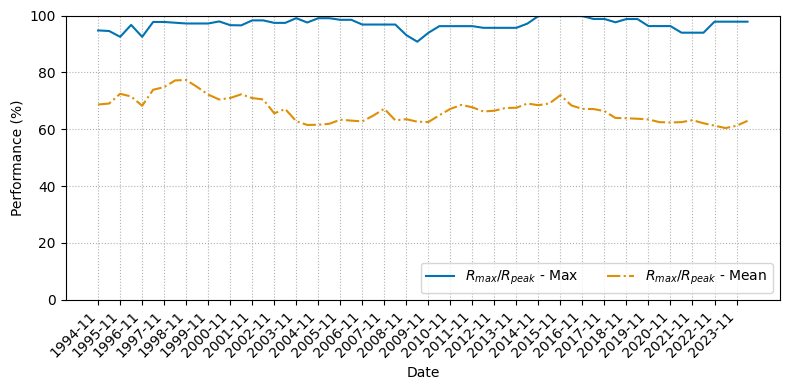

In [13]:
# Plotting: The Performance Ratio Average between Linpack Rmax and Theoretical Rpeak over time for the Top500 System

# Plot settings
plt.figure(figsize=(8, 4))
plt.grid(linestyle='dotted')

# Color palette
colors = sns.color_palette("colorblind")

# Data reformatting for performance ratio
log_df = concat_df.copy(deep=True)

# Calculate the performance percentage (Rmax / Rpeak)
log_df['perf_percent'] = 100 * (log_df['RMax'] / log_df['RPeak'])

# Adjust any cases where performance exceeds 100%
log_df.loc[log_df['perf_percent'] > 100, 'RPeak'] *= 10
log_df['perf_percent'] = 100 * log_df['RMax'] / log_df['RPeak']

# Group by rank year to calculate the mean and max performance percentages
log_df_mean = log_df[['rank_year', 'RMax', 'RPeak', 'perf_percent']].groupby('rank_year').mean().reset_index()
log_df_max = log_df[['rank_year', 'RMax', 'RPeak', 'perf_percent']].groupby('rank_year').max().reset_index()

# Create an index for plotting
log_df_mean['index'] = log_df_mean.index + 1
log_df_max['index'] = log_df_max.index + 1

# Plotting the maximum performance ratio over time
sns.lineplot(data=log_df_max, x='index', y='perf_percent', label=r'$R_{max}/R_{peak}$ - Max', color=colors[0])

# Plotting the mean performance ratio over time
sns.lineplot(data=log_df_mean, x='index', y='perf_percent', label=r'$R_{max}/R_{peak}$ - Mean', color=colors[1], linestyle='dashdot')

# Axis settings and legend
plt.legend(ncol=2, loc='lower right', fontsize=10)
plt.xticks(
    ticks=np.arange(1, max(log_df_max['index']), 2),
    labels=[log_df_max['rank_year'][i] for i in np.arange(1, max(log_df_max['index']), 2)],
    rotation=45, ha='right', fontsize=10
)
plt.ylim(0, 100)  # Set y-axis limits between 0 and 100%

# Axis labels
plt.xlabel('Date')
plt.ylabel('Performance (%)')

# Tight layout to avoid clipping
plt.tight_layout()

# Uncomment to save the figure
# plt.savefig("./figures/performance_ratio.png", format='png', bbox_inches="tight")

# Show the plot
plt.show()


___
#### 9. **GREEN500 :** The Energy Efficiency Evolution in the Green500

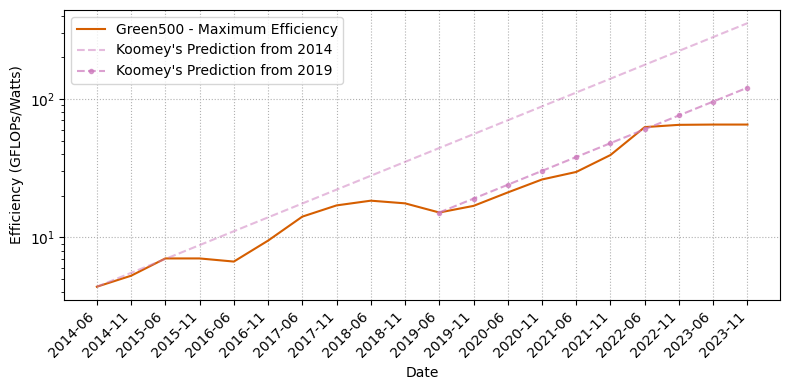

In [14]:
# Plotting: Maximum Efficiency of the Green500 Supercomputers by List Date 
#           Along with Koomey’s Law Projection Starting at Two Different Periods (2014 and 2019)

# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Use a colorblind-friendly palette
colors = sns.color_palette("colorblind")

# Plot parameters
plt.figure(figsize=(8, 4))
plt.grid(linestyle='dotted')

# Copy the dataframe for processing
green_log_df = green_concat_df.copy(deep=True)

# Calculate the maximum efficiency for each year
green_log_df_max = green_log_df[['rank_year', 'G_eff']].groupby('rank_year').max()

# Temporary dataframe for plotting
tmp = green_log_df[['rank_year', 'G_eff']].groupby('rank_year').max().reset_index()

# Plot the maximum efficiency over time
sns.lineplot(data=green_log_df_max, x='rank_year', y='G_eff', label='Green500 - Maximum Efficiency', color=colors[3])

# Koomey's law projection starting from 2014
plt.plot(
    list(tmp.rank_year), 
    [koomey_funct(x, df=tmp, metric='G_eff') for x in list(tmp.index)], 
    label="Koomey's Prediction from 2014", 
    ls='dashed', color=colors[4], alpha=0.5
)

# Koomey's law projection starting from 2019
plt.plot(
    list(tmp.rank_year[10:]), 
    [koomey_funct(x, df=tmp, y=10, metric='G_eff') for x in list(tmp.index)[10:]], 
    label="Koomey's Prediction from 2019", 
    ls='dashed', color=colors[4], marker='.', alpha=0.7
)

# Axis settings
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Date')
plt.ylabel('Efficiency (GFLOPs/Watts)')
plt.xticks(rotation=45, ha='right', fontsize=10)

# Legend settings
plt.legend(ncol=1, loc='upper left', fontsize=10)

# Adjust layout
plt.tight_layout()

# Uncomment to save the figure
# plt.savefig("./figures/green500_efficiency_evolution.png", format='png', bbox_inches="tight")

# Show the plot
plt.show()


#### 10. **GREEN500 :** The Energy Efficiency Growth Comparison Between Heterogeneous and Homogeneous Machines

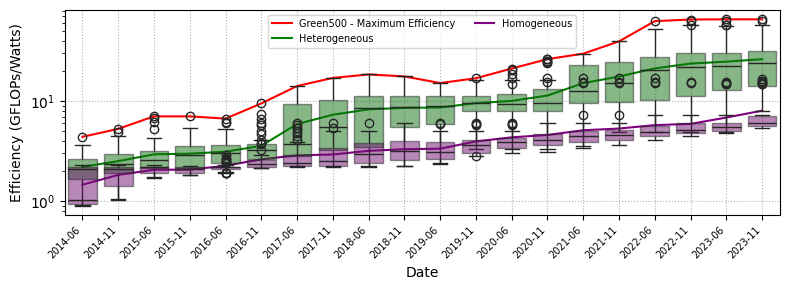

In [15]:
# Plotting: Maximum Energy Efficiency Growth of Green500 Systems by Date Distinguished by Architecture Type (Homogeneous vs. Heterogeneous)

# Plot settings
plt.figure(figsize=(8, 3))

# Split data based on machine type (heterogeneous = with accelerators, homogeneous = without accelerators)
g_gpu = green_concat_df[green_concat_df['Accelerator/Co-Processor'] == 1]  # Heterogeneous systems
g_cpu = green_concat_df[green_concat_df['Accelerator/Co-Processor'] == 0]  # Homogeneous systems

# Plotting maximum efficiency for all Green500 systems over time
sns.lineplot(data=green_concat_df.groupby('rank_year').max(), x='rank_year', y='G_eff', 
             label='Green500 - Maximum Efficiency', color='red')

# Plotting average efficiency for heterogeneous systems over time
sns.lineplot(data=g_gpu[['rank_year', 'G_eff']].groupby('rank_year').mean(), x='rank_year', y='G_eff', 
             label='Heterogeneous', color='green')

# Plotting average efficiency for homogeneous systems over time
sns.lineplot(data=g_cpu[['rank_year', 'G_eff']].groupby('rank_year').mean(), x='rank_year', y='G_eff', 
             label='Homogeneous', color='purple')

# Adding boxplots to visualize distribution of efficiencies by year for both heterogeneous and homogeneous systems
sns.boxplot(data=g_gpu[['rank_year', 'G_eff', 'Accelerator/Co-Processor']], x='rank_year', y='G_eff', 
            color='green', boxprops=dict(alpha=0.5))

sns.boxplot(data=g_cpu[['rank_year', 'G_eff', 'Accelerator/Co-Processor']], x='rank_year', y='G_eff', 
            color='purple', boxprops=dict(alpha=0.5))

# Axis settings
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlabel('Date')
plt.ylabel('Efficiency (GFLOPs/Watts)')
plt.grid(linestyle='dotted')

# Legend settings
plt.legend(ncol=2, loc='upper center', fontsize=7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=7)

# Tight layout to avoid overlapping elements
plt.tight_layout()

# Uncomment to save the figure
# plt.savefig("./figures/green500_heterogeneity_vs_homogeneity.png", format='png', bbox_inches="tight")

# Show the plot
plt.show()


#### 11. **GREEN500 :** The Number of New Heterogeneous and Homogeneous Machines (per Year) 

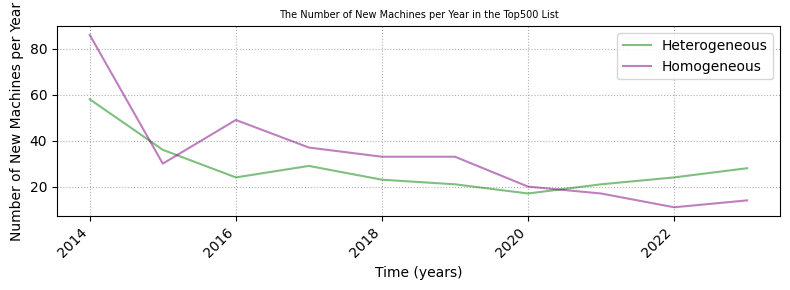

In [16]:
# Plotting: The Number of New Machines per Year in the Top500 List by Machine Type (Heterogeneous vs. Homogeneous)

# Plot settings
plt.figure(figsize=(8, 3))
plt.grid(linestyle='dotted')
plt.title('The Number of New Machines per Year in the Top500 List', fontsize=7)

# Data reformatting
g_df = green_concat_df.copy(deep=True)

# Create a combined 'rank_year' column
g_df['rank_year'] = g_df[['TOP500 Rank', 'rank_year']].apply(lambda x: [x['TOP500 Rank'], x['rank_year']], axis=1)

# Group by relevant columns and aggregate the 'rank_year' values
g_df = g_df.groupby(['Computer', 'Year', 'Country', 'Cores', 'Accelerator/Co-Processor'])['rank_year'].apply(list)

# Function to calculate the minimum rank
def calc_min(l):
    m = int(l[0][0])
    for x in l:
        if x[0] < m:
            m = x[0]
    return m

# Function to calculate the first appearance year
def calc_rank(l):
    m = int(str(l[0][1]).split('-')[0])
    for x in l:
        if int(x[1].split('-')[0]) < m:
            m = int(x[1].split('-')[0])
    return m

# Reset the index and apply functions to calculate the minimum rank and first appearance year
g_df = g_df.reset_index()
g_df['min_rank'] = g_df['rank_year'].apply(calc_min)
g_df['apparition year'] = g_df['rank_year'].apply(calc_rank)

# Separate the data for heterogeneous and homogeneous systems
dataG = g_df[g_df['Accelerator/Co-Processor'] == 1][['apparition year', 'Computer']].groupby('apparition year').count()
dataC = g_df[g_df['Accelerator/Co-Processor'] == 0][['apparition year', 'Computer']].groupby('apparition year').count()

# Rename columns for easier plotting
dataG.rename(columns={'Computer': 'Number of Machines'}, inplace=True)
dataC.rename(columns={'Computer': 'Number of Machines'}, inplace=True)

# Reset index for both datasets
dataG.reset_index(inplace=True)
dataC.reset_index(inplace=True)

# Plotting the number of machines per year for heterogeneous and homogeneous systems
sns.lineplot(data=dataG, x='apparition year', y='Number of Machines', color='green', alpha=0.5, label='Heterogeneous')
sns.lineplot(data=dataC, x='apparition year', y='Number of Machines', color='purple', alpha=0.5, label='Homogeneous')

# Axis settings
plt.xlabel('Time (years)')
plt.ylabel('Number of New Machines per Year')
plt.xticks(rotation=45, ha='right', fontsize=10)

# Adjust layout to avoid overlapping elements
plt.tight_layout()

# Uncomment to save the figure
# plt.savefig("./figures/top500_nbr_new_machines_per_machine_type.png", format='png', bbox_inches="tight")

# Show the plot
plt.show()


___
___


In [17]:
# uploading the carbon intensity of each country by year for our next analysis
carbon_df = pd.read_csv('./data/carbon_intensity_by_country.csv')
carbon_df[carbon_df['Entity'] == 'France']
carbon_df['Country'] = carbon_df['Entity']

In [18]:
# Creating a copy of the previous dataframe
n_concat_df = green_concat_df.copy(deep=True)
n_concat_df = n_concat_df.merge(carbon_df, on=['Year', 'Country'])

# adding some useful columns for our analysis : electric consumption, carbon footprint and GFlop/KgCO2
n_concat_df['electric_consumption (GWh)'] = n_concat_df['Power'] * 365.25 * 24 / 1e6
n_concat_df['Carbon footprint (TCO2)'] = n_concat_df['Carbon intensity of electricity - gCO2/kWh'] * n_concat_df['electric_consumption (GWh)']  # Kg co2 per GWh
n_concat_df['GFlops/KgCO2'] = n_concat_df['RMax'] * 365.25 * 24 * 3600 / (n_concat_df['Carbon footprint (TCO2)'] * 1000) # Gflop per KgCO2

#### 12. **ENERGY:** Evolution of Maximum Performance in GFLOP per kgCO2

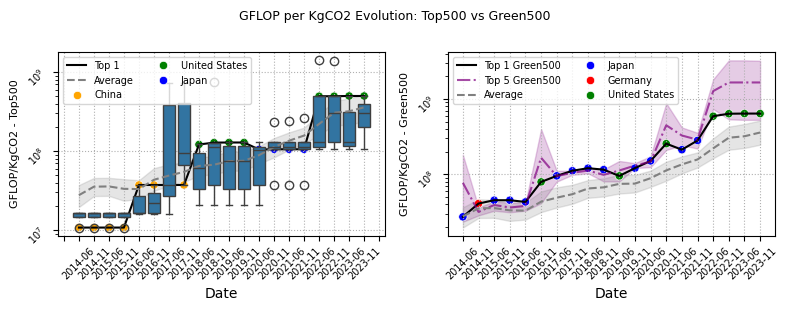

In [19]:
# Plotting: Evolution of Maximum Performance in GFLOP per kgCO2 for Top 1 & Top 5 Systems in the Top500 [Left] and Green500 [Right]


# Plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3))
plt.grid(linestyle='dotted')

# Filter data for Top 1, Top 5, and mean performance in the Top500 and Green500
log_df_max = n_concat_df[n_concat_df['TOP500 Rank'] == 1]  # Top 1 in Top500
log_df_5 = n_concat_df[n_concat_df['TOP500 Rank'] <= 5]    # Top 5 in Top500
log_df_mean = n_concat_df                                  # Mean in Top500

g_log_df_max = n_concat_df[n_concat_df['Rank'] == 1]        # Top 1 in Green500
g_log_df_5 = n_concat_df[n_concat_df['Rank'] <= 5]          # Top 5 in Green500

# Plotting for Top500 systems [Left subplot]
sns.lineplot(data=log_df_max, x='rank_year', y='GFlops/KgCO2', label='Top 1', color='black', ax=ax[0])
sns.boxplot(data=log_df_5, x='rank_year', y='GFlops/KgCO2', ax=ax[0])
sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='Average', color='grey', linestyle='--', ax=ax[0])
sns.scatterplot(data=log_df_max, x='rank_year', y='GFlops/KgCO2', hue='Country', ax=ax[0], palette=['orange', 'green', 'blue'])

# Plotting for Green500 systems [Right subplot]
sns.lineplot(data=g_log_df_max, x='rank_year', y='GFlops/KgCO2', label='Top 1 Green500', color='black', ax=ax[1])
sns.lineplot(data=g_log_df_5, x='rank_year', y='GFlops/KgCO2', label='Top 5 Green500', color='purple', linestyle='-.', alpha=0.7, ax=ax[1])
sns.lineplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', label='Average', color='grey', linestyle='--', ax=ax[1])
sns.scatterplot(data=g_log_df_max, x='rank_year', y='GFlops/KgCO2', hue='Country', ax=ax[1], palette=['blue', 'red', 'green'])

# Axis settings for both subplots
for i in [0, 1]:
    ax[i].set_yscale('log')  # Set y-axis to log scale
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    loc = plticker.MultipleLocator(base=1.0)  # Set x-axis tick intervals
    ax[i].xaxis.set_major_locator(loc)
    ax[i].legend(ncol=2, loc='upper left', fontsize=7)
    ax[i].set_xlabel('Date')

# Set y-axis labels for each subplot
ax[0].set_ylabel('GFLOP/KgCO2 - Top500', fontsize=8)
ax[1].set_ylabel('GFLOP/KgCO2 - Green500', fontsize=8)

# Layout and title settings
plt.tight_layout()
figure.suptitle('GFLOP per KgCO2 Evolution: Top500 vs Green500', fontsize=9, y=1.02)
figure.subplots_adjust(top=0.88)

# Uncomment to save the figure
# plt.savefig('./figures/flops_per_kgco2.png', format="png", bbox_inches="tight")

# Show the plot
plt.show()


#### 13. **ENERGY:** Evolution of Maximum Performance in GFLOP (With Future Projections)

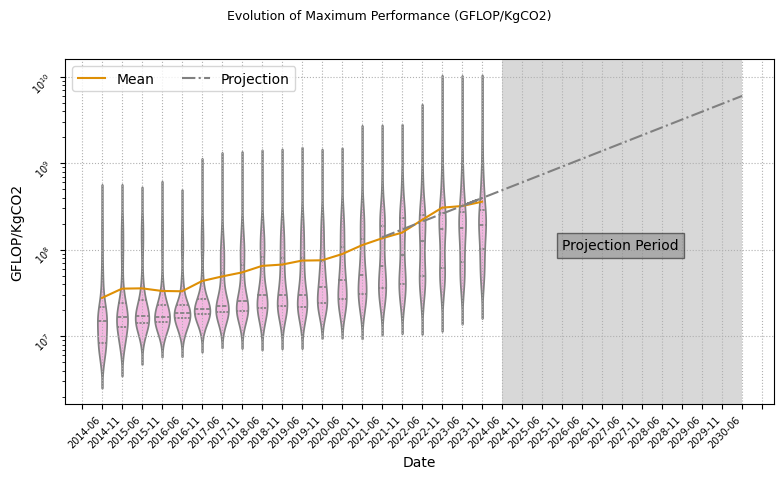

In [20]:
# Plotting: Evolution of Maximum Performance in GFLOP per kgCO2 for Top500 Systems with Projection

# Plot settings
figure, ax = plt.subplots(1, 1, figsize=(8, 5))  # Single plot
plt.grid(linestyle='dotted')
plt.yscale('log')

# Setting colorblind palette
colors = sns.color_palette("colorblind")

# Data reformatting for mean and max values
log_df_max = n_concat_df[n_concat_df['TOP500 Rank'] == 1]  # Top 1 systems
log_df_5 = n_concat_df[n_concat_df['TOP500 Rank'] <= 5]    # Top 5 systems
log_df_mean = n_concat_df                                  # All systems (mean)

g_log_df_max = n_concat_df[n_concat_df['Rank'] == 1]       # Top 1 systems in Green500
g_log_df_5 = n_concat_df[n_concat_df['Rank'] <= 5]         # Top 5 systems in Green500

# Plotting the mean GFLOP/KgCO2 evolution over time
sns.lineplot(data=log_df_mean[['rank_year', 'GFlops/KgCO2']].groupby('rank_year').mean(), 
             color=colors[1], x='rank_year', y='GFlops/KgCO2', label='Mean', ax=ax)

# Adding a violin plot for the distribution of GFLOP/KgCO2
sns.violinplot(data=log_df_mean, x='rank_year', y='GFlops/KgCO2', ax=ax, color=colors[6], inner="quart")

# Function to fit exponential curve
def exp_funct(x: float, a: float, b: float):
    """Exponential function used for fitting."""
    return a * np.power(np.exp(x), b)

# Function to calculate Moore's prediction (used for projection)
def mm_funct(x: float, df: pd.DataFrame, metric: str = "RMax"):
    """Moore's prediction for the performance evolution."""
    return df.iloc[0][metric] * 2 ** (x / 4)

# Data for curve fitting
mm = log_df_mean[['rank_year', 'GFlops/KgCO2']].groupby('rank_year').mean().reset_index()

# Curve fitting for projection
idx = len(mm['GFlops/KgCO2']) - 6  # Last 6 data points for fitting

# Perform linear regression on the log-transformed data
x = np.array(list(mm.index)[idx:])
y = list(mm["GFlops/KgCO2"])[idx:]
log_y = np.log(y)
slope, intercept, _, _, _ = linregress(x, log_y)

# Generate the regression line with future projections
x_new = np.array(list(x) + [17 + i for i in range(1, 16)])  # Future projection points
regression_line = np.exp(intercept + slope * x_new)

# Plot the projection line
plt.plot(
    list(log_df_mean['rank_year'].unique()[idx:]) + [
        '2023-06', '2023-11', '2024-06', '2024-11', '2025-06', '2025-11', '2026-06', '2026-11', '2027-06', 
        '2027-11', '2028-06', '2028-11', '2029-06', '2029-11', '2030-06'
    ], 
    regression_line, color="grey", linestyle="dashdot", label='Projection'
)

# Layout and axis settings
plt.legend(ncol=2, loc='upper center', fontsize="10")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()

# Add a shaded area to represent the projection period
plt.axvspan(20, 32, facecolor='grey', alpha=0.3)

# Axis settings
loc = plticker.MultipleLocator(base=1.0)  # Set x-axis ticks at every year
ax.xaxis.set_major_locator(loc)
ax.set_xlabel('Date')
ax.set_yscale('log')  # Set y-axis to logarithmic scale
ax.grid(linestyle='dotted')
ax.tick_params(labelrotation=45, labelsize=7)
ax.legend(ncol=2, loc='upper left', fontsize="10")

# Set y-axis label
ax.set_ylabel('GFLOP/KgCO2', fontsize=10)

# Add a text label to indicate projection period
ax.text(23, 1e8, 'Projection Period', fontsize=10, bbox=dict(facecolor='grey', alpha=0.5))

# Title and adjustments
figure.suptitle('Evolution of Maximum Performance (GFLOP/KgCO2)', fontsize=9)
figure.subplots_adjust(top=0.88)

# Uncomment to save the figure
# plt.savefig('./figures/flops_per_kgco2_proj.png', format="png", bbox_inches="tight")

# Show the plot
plt.show()


#### 14. **ENERGY:** Electric Consumption & Carbon Footprint in Top500 Over Time

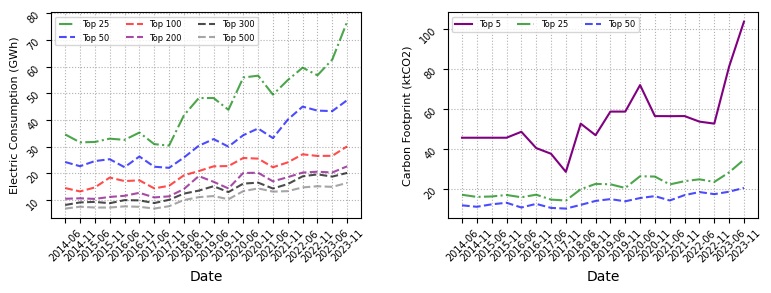

In [21]:
# Plotting: Electric Consumption & Carbon Footprint for the Top 5, 25, 50 Systems in Top500 Over Time

# Import required libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as plticker

# Plot settings
figure, ax = plt.subplots(1, 2, figsize=(8, 3))  # Create subplots for electric consumption and carbon footprint

# Convert carbon footprint to kilotons
n_concat_df['Carbon footprint (ktCO2)'] = n_concat_df['Carbon footprint (TCO2)'] / 1e3

# Data reformatting for top 5 and mean
log_df_max = n_concat_df[n_concat_df['TOP500 Rank'] <= 5]   # Top 5 systems
log_df_mean = n_concat_df                                   # Mean for all systems

# Plot electric consumption (GWh) for different top system groups in the first subplot
sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 25], x='rank_year', y='electric_consumption (GWh)', 
             label='Top 25', markers=True, color='green', ax=ax[0], alpha=0.7, ci=None, linestyle='dashdot')
sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 50], x='rank_year', y='electric_consumption (GWh)', 
             label='Top 50', markers=True, color='blue', ax=ax[0], alpha=0.7, ci=None, linestyle='dashed')
sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 100], x='rank_year', y='electric_consumption (GWh)', 
             label='Top 100', markers=True, color='red', ax=ax[0], alpha=0.7, ci=None, linestyle='dashed')
sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 200], x='rank_year', y='electric_consumption (GWh)', 
             label='Top 200', markers=True, color='purple', ax=ax[0], alpha=0.7, ci=None, linestyle='dashed')
sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 300], x='rank_year', y='electric_consumption (GWh)', 
             label='Top 300', markers=True, color='black', ax=ax[0], alpha=0.7, ci=None, linestyle='dashed')
sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 500], x='rank_year', y='electric_consumption (GWh)', 
             label='Top 500', markers=True, color='grey', ax=ax[0], alpha=0.7, ci=None, linestyle='dashed')

# Plot carbon footprint (ktCO2) for different top system groups in the second subplot
sns.lineplot(data=log_df_max, x='rank_year', y='Carbon footprint (ktCO2)', label='Top 5', color='purple', ax=ax[1], ci=None)
sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 25], x='rank_year', y='Carbon footprint (ktCO2)', 
             label='Top 25', markers=True, color='green', ax=ax[1], alpha=0.7, ci=None, linestyle='dashdot')
sns.lineplot(data=log_df_mean[log_df_mean['TOP500 Rank'] <= 50], x='rank_year', y='Carbon footprint (ktCO2)', 
             label='Top 50', markers=True, color='blue', ax=ax[1], alpha=0.7, ci=None, linestyle='dashed')

# Layout settings
plt.tight_layout()

# Axis settings
loc = plticker.MultipleLocator(base=1.0)  # Set x-axis tick intervals to 1 year
for i in range(2):  # Iterate over both subplots
    ax[i].xaxis.set_major_locator(loc)
    ax[i].set_xlabel('Date')
    ax[i].grid(linestyle='dotted')
    ax[i].tick_params(labelrotation=45, labelsize=7)
    ax[i].legend(ncol=3, loc='upper left', fontsize="6")

# Set y-axis labels for both subplots
ax[0].set_ylabel('Electric Consumption (GWh)', fontsize=8)
ax[1].set_ylabel('Carbon Footprint (ktCO2)', fontsize=8)

# Adjust the layout for the figure
figure.subplots_adjust(top=0.88)

# Uncomment to save the figure
# plt.savefig('./figures/top500_conso_co2.png', format='png', bbox_inches='tight')

# Show the plot
plt.show()


___
